# 3.3 OpenAI API Deep Dive — Vision Capabilities (GPT-4o-mini)

## Playground Notebook

GPT-4o-mini is a **multimodal** model — it can see and understand images alongside text.

| Capability | Examples |
|------------|----------|
| **Describe images** | What's in this photo? |
| **Read text in images** | OCR from screenshots, documents, signs |
| **Analyze charts** | Interpret data visualizations |
| **Compare images** | Spot differences between two images |
| **Reason about visuals** | What's wrong with this UI? |

### Two Ways to Send Images

| Method | When to Use |
|--------|-------------|
| **URL** | Image is publicly hosted online |
| **Base64** | Local files not hosted anywhere |

> **Model:** `gpt-4o-mini` — supports vision at lower cost.

---

In [1]:
import os
import base64
import time
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import display, Markdown, HTML, Image

load_dotenv()

MODEL = "gpt-4o-mini"
client = OpenAI()

print(f"\u2705 Client ready | Model: {MODEL}")

✅ Client ready | Model: gpt-4o-mini


In [2]:
# ============================================================
#  HELPER FUNCTIONS
# ============================================================

def vision_url(prompt, image_url, detail="low", max_tokens=100):
    """Send an image URL to the model for analysis."""
    start = time.time()
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": image_url, "detail": detail}}
            ]
        }],
        max_tokens=max_tokens
    )
    elapsed = time.time() - start
    content = response.choices[0].message.content
    display(Markdown(content))
    print(f"\n\u23f1\ufe0f {elapsed:.2f}s | Tokens: {response.usage.total_tokens}")
    return response


def vision_base64(prompt, image_path, detail="low", max_tokens=100):
    """Send a local image file as base64."""
    with open(image_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")

    # Detect mime type from extension
    ext = os.path.splitext(image_path)[1].lower()
    mime = {"jpg": "jpeg", "jpeg": "jpeg", "png": "png", "gif": "gif", "webp": "webp"}
    media_type = mime.get(ext.lstrip("."), "png")

    start = time.time()
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {
                    "url": f"data:image/{media_type};base64,{b64}",
                    "detail": detail
                }}
            ]
        }],
        max_tokens=max_tokens
    )
    elapsed = time.time() - start
    content = response.choices[0].message.content
    display(Markdown(content))
    print(f"\n\u23f1\ufe0f {elapsed:.2f}s | Tokens: {response.usage.total_tokens}")
    return response


print("\u2705 Vision helpers loaded")

✅ Vision helpers loaded


---

## 1. Image URL — Analyzing Online Images

### Experiment 1A: Describe an Image from URL

In [3]:
# Image URL
IMAGE_URL = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/refs/heads/master/ComputerVision/Images/dog.jpg"

# Show the image in notebook
display(Image(url=IMAGE_URL, width=400))

print("\nAsking GPT-4o-mini to describe this image...\n")
_ = vision_url("Describe this image in 2 sentences.", IMAGE_URL, max_tokens=60)


Asking GPT-4o-mini to describe this image...



The image features a small brown dachshund standing on a wooden deck at sunset. The soft glow of the sunset creates a warm ambiance, enhancing the dog's features and showcasing its alert expression.


⏱️ 2.05s | Tokens: 2886


### Experiment 1B: Reading Text from an Image (OCR)

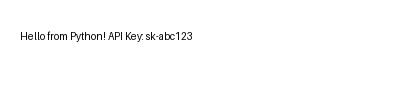


Asking model to read the text...



Hello from Python! API Key: sk-abc123


⏱️ 1.08s | Tokens: 2859


In [4]:
# Create a simple image with text using PIL
try:
    from PIL import Image as PILImage, ImageDraw, ImageFont

    img = PILImage.new('RGB', (400, 100), color='white')
    draw = ImageDraw.Draw(img)
    draw.text((20, 30), "Hello from Python! API Key: sk-abc123", fill='black')
    img.save('test_ocr.png')

    display(Image(filename='test_ocr.png'))
    print("\nAsking model to read the text...\n")
    _ = vision_base64("Read all text in this image exactly.", "test_ocr.png", max_tokens=40)

except ImportError:
    print("PIL not installed. Using a URL image for OCR demo instead.")
    # Fallback: use any public image with text
    _ = vision_url(
        "Read any text visible in this image.",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Google_2015_logo.svg/800px-Google_2015_logo.svg.png",
        max_tokens=30
    )

---

## 2. Base64 — Sending Local Image Files

### Experiment 2A: Analyze a Local Image

In [5]:
# Check if image.png exists in the project directory
local_image = "image.png"

if os.path.exists(local_image):
    display(Image(filename=local_image, width=400))
    print(f"\nAnalyzing {local_image}...\n")
    _ = vision_base64("Describe what you see in this image. Be brief.", local_image, max_tokens=80)
else:
    print(f"\u26a0\ufe0f {local_image} not found. Place an image file here to test local analysis.")
    print("   The base64 encoding pattern is shown in the helper function above.")

⚠️ image.png not found. Place an image file here to test local analysis.
   The base64 encoding pattern is shown in the helper function above.


### Experiment 2B: How Base64 Encoding Works

In [6]:
# Demonstrate the encoding process
try:
    from PIL import Image as PILImage, ImageDraw

    # Create a tiny test image
    img = PILImage.new('RGB', (100, 50), color='#3498db')
    draw = ImageDraw.Draw(img)
    draw.text((10, 15), "Test", fill='white')
    img.save('tiny_test.png')

    # Show the encoding
    with open('tiny_test.png', 'rb') as f:
        raw_bytes = f.read()
        b64_string = base64.b64encode(raw_bytes).decode('utf-8')

    print(f"File size:     {len(raw_bytes)} bytes")
    print(f"Base64 length: {len(b64_string)} characters")
    print(f"Base64 ratio:  {len(b64_string)/len(raw_bytes):.1f}x (base64 is ~33% larger)")
    print(f"\nFirst 80 chars: {b64_string[:80]}...")
    print(f"\nThe URL sent to the API:")
    print(f"  data:image/png;base64,{b64_string[:40]}...")

except ImportError:
    print("PIL not available. The concept: read file bytes \u2192 base64 encode \u2192 embed in URL.")

File size:     544 bytes
Base64 length: 728 characters
Base64 ratio:  1.3x (base64 is ~33% larger)

First 80 chars: iVBORw0KGgoAAAANSUhEUgAAAGQAAAAyCAIAAAAlV+npAAAB50lEQVR4nO3ZO0hbURzH8f893rTmQUzU...

The URL sent to the API:
  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAGQAAAAyCAIAAAAl...


---

## 3. Detail Levels — Cost vs. Accuracy

The `detail` parameter controls how the model processes the image:

| Level | Resolution | Tokens | Best For |
|-------|-----------|--------|----------|
| `low` | Fixed 512x512 | ~85 tokens | Quick descriptions, thumbnails |
| `high` | Up to 2048x2048 | 85-1105 tokens | Reading small text, detailed analysis |
| `auto` | Model decides | Varies | General use |

### Experiment 3A: Low vs High Detail Comparison

In [7]:
TEST_URL = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"

for detail_level in ["low", "high"]:
    print(f"\n{'=' * 50}")
    print(f"  detail='{detail_level}'")
    print(f"{'=' * 50}")
    _ = vision_url(
        "Describe this in 1 sentence.",
        TEST_URL,
        detail=detail_level,
        max_tokens=50
    )

print("\n\u2139\ufe0f Notice the token count difference — 'high' costs more but sees more detail.")


  detail='low'


The image features three colorful dice in blue, green, and red, each adorned with white dots.


⏱️ 1.40s | Tokens: 2867

  detail='high'


The image features three colorful dice—red, blue, and green—displaying white dots against a vibrant, multicolored background.


⏱️ 1.54s | Tokens: 25542

ℹ️ Notice the token count difference — 'high' costs more but sees more detail.


---

## 4. Practical Use Cases

### Experiment 4A: Structured Data Extraction from Image

In [8]:
import json

# Combine vision with structured output
print("=" * 60)
print("Vision + JSON Mode — Structured extraction from an image")
print("=" * 60)

# Use a reliably accessible image URL; some Wikimedia thumbnails return 403 errors
img_url = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/refs/heads/master/ComputerVision/Images/dog.jpg"

response = vision_url(
    "Identify this type of dog . Return JSON with keys: kind, rarity, notable features. JSON only.",
    img_url,
    max_tokens=80
)

text = response.choices[0].message.content
try:
    parsed = json.loads(text)
    print(f"\n\u2705 Valid JSON! Parsed:")
    print(json.dumps(parsed, indent=2))
except json.JSONDecodeError:
    print("\u26a0\ufe0f Response was not strict JSON — but the data is still extracted above.")

Vision + JSON Mode — Structured extraction from an image


```json
{
  "kind": "Dachshund",
  "rarity": "Common",
  "notable features": ["Long body", "Short legs", "Distinctive ear shape"]
}
```


⏱️ 1.76s | Tokens: 2905
⚠️ Response was not strict JSON — but the data is still extracted above.


### Experiment 4B: Multiple Images in One Request

In [9]:
# Send two images for comparison
print("=" * 60)
print("Multiple Images — Comparing two logos")
print("=" * 60)

# We need a custom call here since vision_url handles single images
# The original Wikimedia SVG thumbnails sometimes return 403; use guaranteed-access URLs
img1 = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/refs/heads/master/ComputerVision/Images/dog.jpg"
img2 = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"

start = time.time()
response = client.chat.completions.create(
    model=MODEL,
    messages=[{
        "role": "user",
        "content": [
            {"type": "text", "text": "Compare these two images in 2 sentences."},
            {"type": "image_url", "image_url": {"url": img1, "detail": "low"}},
            {"type": "image_url", "image_url": {"url": img2, "detail": "low"}}
        ]
    }],
    max_tokens=80
)
elapsed = time.time() - start

display(Markdown(response.choices[0].message.content))
print(f"\n\u23f1\ufe0f {elapsed:.2f}s | Tokens: {response.usage.prompt_tokens}+{response.usage.completion_tokens}={response.usage.total_tokens}")

Multiple Images — Comparing two logos


The first image features a dachshund standing on a wooden deck during sunset, showcasing a peaceful outdoor setting. In contrast, the second image displays colorful dice floating against a vibrant background, conveying a sense of playfulness and chance associated with games.


⏱️ 2.03s | Tokens: 5682+49=5731


### Experiment 4C: Multi-Turn Vision — Model Remembers the Image

In [10]:
# Use a URL that the API can fetch; some Wikimedia URLs return 403 errors.
IMG = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/refs/heads/master/ComputerVision/Images/dog.jpg"

# Turn 1: Send the image
print("=" * 60)
print("TURN 1 — Send image + question")
print("=" * 60)

messages = [
    {"role": "user", "content": [
        {"type": "text", "text": "What animal is this? One sentence."},
        {"type": "image_url", "image_url": {"url": IMG, "detail": "low"}}
    ]}
]

r1 = vision_url("What animal is this? One sentence.", IMG, max_tokens=40)
a1 = r1.choices[0].message.content

# Turn 2: Follow-up WITHOUT resending the image
print(f"\n{'=' * 60}")
print("TURN 2 — Follow-up (no image resent)")
print("=" * 60)

messages.append({"role": "assistant", "content": a1})
messages.append({"role": "user", "content": "What color is it?"})

start = time.time()
r2 = client.chat.completions.create(model=MODEL, messages=messages, max_tokens=40)
elapsed = time.time() - start

display(Markdown(r2.choices[0].message.content))
print(f"\n\u23f1\ufe0f {elapsed:.2f}s | Tokens: {r2.usage.prompt_tokens}+{r2.usage.completion_tokens}={r2.usage.total_tokens}")
print(f"\n\u2705 The model remembers the image from Turn 1 — no need to resend it!")

TURN 1 — Send image + question


This is a dachshund, a breed of dog known for its long body and short legs.


⏱️ 1.01s | Tokens: 2868

TURN 2 — Follow-up (no image resent)


The dachshund in the image is a reddish-brown color.


⏱️ 1.12s | Tokens: 2881+14=2895

✅ The model remembers the image from Turn 1 — no need to resend it!


---

## 5. Limitations

| Limitation | Details |
|------------|--------|
| **No spatial precision** | Cannot give exact pixel coordinates |
| **Small text** | May struggle with tiny text — use `detail="high"` |
| **Specialized images** | Medical/satellite imagery — not trained for professional diagnosis |
| **CAPTCHA / faces** | Will refuse for safety reasons |
| **Image size** | Max 20MB per image; auto-resized to fit token budget |

---

## Key Takeaways

| Concept | What to Remember |
|---------|------------------|
| **Multimodal** | GPT-4o-mini handles images + text in the same request |
| **URL method** | `{"type": "image_url", "image_url": {"url": "..."}}` |
| **Base64 method** | `data:image/png;base64,{encoded}` for local files |
| **detail** | `low` = cheap/fast (85 tokens), `high` = detailed (up to 1105 tokens) |
| **Multiple images** | Send several images in one `content` array |
| **Multi-turn** | Image is remembered — no need to resend in follow-up turns |
| **+ Structured** | Combine vision with JSON mode for data extraction |